# EJERCICIOS

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Concatenate
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import os

## EJERCICIO 1


Supongamos que queremos predecir dos objetivos diferentes (por ejemplo, precio y categoría) a partir de dos conjuntos de características diferentes (por ejemplo, características visuales y características de texto de un producto).

* Características visuales: un conjunto de 128 características numéricas, que podrían representar, por ejemplo, valores de píxeles o características extraídas de imágenes.
* Características de texto: un conjunto de 256 características numéricas, representando posiblemente la codificación de texto o características lingüísticas.
* Precio (Salida 1): un valor numérico que representa el precio de un producto.
* Categoría (Salida 2): una etiqueta de categoría, que asumiremos que puede tomar 10 valores diferentes (por ejemplo, 10 categorías diferentes de productos).

Voy a generar datos aleatorios

In [3]:
# Generación de datos ficticios
num_muestras = 1000  # Número de muestras en el conjunto de datos

# Características visuales: 128 características numéricas
caracteristicas_visuales = np.random.rand(num_muestras, 128)

# Características de texto: 256 características numéricas
caracteristicas_texto = np.random.rand(num_muestras, 256)

# Precio (Salida 1): Valor numérico (por ejemplo, precio de un producto)
precio = np.random.rand(num_muestras, 1)

# Categoría (Salida 2): 10 categorías posibles (codificadas en one-hot)
categorias = np.random.randint(0, 10, size=(num_muestras, 1))
categorias_one_hot = tf.keras.utils.to_categorical(categorias, num_classes=10)

Divide los datos en entrenamiento y prueba

In [4]:
x_vis_train, x_vis_test, x_text_train, x_text_test, y_precio_train, y_precio_test, y_cat_train, y_cat_test = train_test_split(
    caracteristicas_visuales,
    caracteristicas_texto,
    precio,
    categorias_one_hot,
    test_size=0.2,
    random_state=42)

Construye el modelo:
* Crea dos ramas de entrada, una para cada tipo de características.
* Las ramas se fusionarán para predecir el precio.
* Una de las ramas se utilizará también para predecir la categoria.

El esquema es el siguiente:

<img src="Datos/esquema_modelo_funcional.png" alt="esquema modelo funcional"/>

In [5]:
# Limpiar sesión y establecer semilla
tf.keras.backend.clear_session()
tf.random.set_seed(17)

# Definir entradas
input_visual = tf.keras.layers.Input(shape=(128,), name="Input_Visual")
input_texto = tf.keras.layers.Input(shape=(256,), name="Input_Texto")

# Rama visual
hidden_visual = tf.keras.layers.Dense(64, activation="relu", name="oculta_visual")(input_visual)

# Rama de texto más profunda
hidden_texto = tf.keras.layers.Dense(128, activation="relu", name="oculta_texto_1")(input_texto)
hidden_texto = tf.keras.layers.Dense(64, activation="relu", name="oculta_texto_2")(hidden_texto)

# Concatenación de ambas ramas
combinacion = tf.keras.layers.Concatenate(name="features")([hidden_visual, hidden_texto])

# Salida de categoría basada en la rama de texto
salida_categoria = tf.keras.layers.Dense(10, activation="softmax", name="salida_categoria")(hidden_texto)

# Salida de precio basada en la combinación
salida_precio = tf.keras.layers.Dense(1, name="salida_precio")(combinacion)

# Definir modelo
model = tf.keras.Model(inputs=[input_visual, input_texto], outputs=[salida_categoria, salida_precio])

# Resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Texto         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ oculta_texto_1      │ (None, 128)       │     32,896 │ Input_Texto[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Visual        │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ oculta_texto_2      │ (None, 64)        │      8,256 │ oculta_texto_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ oculta_visual       │ (None, 64)        │      8,256 │ Input_Visual[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 128)       │          0 │ oculta_visual[0]… │
│ (Concatenate)       │                   │            │ oculta_texto_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salida_categoria    │ (None, 10)        │        650 │ oculta_texto_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ salida_precio       │ (None, 1)         │        129 │ features[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,187 (196.04 KB)

 Trainable params: 50,187 (196.04 KB)

 Non-trainable params: 0 (0.00 B)

Comprueba creando una imagen del modelo que es igual que el que se pide

In [20]:
tf.keras.utils.plot_model(model, "modelo.png", show_shapes=True)


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Lo tengo todo instalado pero no me funciona, probar en el pc de clase

Compila el modelo especificando las pérdidas y métricas para cada salida (utiliza el optimizador Adam)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss={
        "salida_categoria": "categorical_crossentropy", # Clasificacion
        "salida_precio": "mse" # Regresion
    },
    metrics={
        "salida_categoria": ["accuracy"], # Clasificacion
        "salida_precio": ["mae"] # Regresion
    }
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

Entrena el modelo 

In [8]:
history = model.fit(
    [x_vis_train, x_text_train],
    [y_cat_train, y_precio_train],
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_cb]
)

Epoch 1/10


c:\Users\irune\OneDrive\Desktop\IABD\SAPA\SAPA\SAPA\.conda\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Input_Visual', 'Input_Texto']. Received: the structure of inputs=('*', '*')
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.6298 - salida_categoria_accuracy: 0.1057 - salida_categoria_loss: 2.4157 - salida_precio_loss: 0.2140 - salida_precio_mae: 0.3749 - val_loss: 2.4942 - val_salida_categoria_accuracy: 0.1063 - val_salida_categoria_loss: 2.3462 - val_salida_precio_loss: 0.1480 - val_salida_precio_mae: 0.3155
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4763 - salida_categoria_accuracy: 0.1080 - salida_categoria_loss: 2.3418 - salida_precio_loss: 0.1346 - salida_precio_mae: 0.3016 - val_loss: 2.4458 - val_salida_categoria_accuracy: 0.1312 - val_salida_categoria_loss: 2.3148 - val_salida_precio_loss: 0.1310 - val_salida_precio_mae: 0.2986
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4387 - salida_categoria_accuracy: 0.1189 - salida_categoria_loss: 2.3132 - salida_precio_loss: 0.1256 - salida_precio_mae: 0.2893 - val_loss: 2.4318 - val_salida_categoria_accuracy: 0.1312 - val_salida_categoria_loss: 2.3031 - val_salida_precio_loss:

Evalúa el modelo en el conjunt de pruebas

In [9]:
results = model.evaluate(
    [x_vis_test, x_text_test], 
    [y_cat_test, y_precio_test]
)

print(f"Loss: {results[0]}")
print(f"Exactitud - Categoría: { results[1]}")
print(f"MAE - Precio: {results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4504 - salida_categoria_accuracy: 0.1354 - salida_categoria_loss: 2.3141 - salida_precio_loss: 0.1337 - salida_precio_mae: 0.2979  
Loss: 2.437218427658081
Exactitud - Categoría: 2.2997775077819824
MAE - Precio: 0.12720727920532227


## EJERCICIO 2

El objetivo de este ejercicio es entrenar un modelo en un subconjunto de clases (Modelo A) y luego usar este modelo para entrenar otro modelo en un subconjunto diferente de clases (Modelo B), primero sin y luego con el conocimiento transferido del Modelo A.

Carga los datos de CIFAR-10, representa alguna de sus imágenes con sus etiquetas, haz una lista con las etiquetas que tiene (busca en internet) y normaliza los datos dividiendo entre 255.0.

Divide los datos en conjuntos de entrenamiento, pruebas y validación para el modelo A y para el modelo B:
* El modelo A utiliza las clases "avión", "automóvil", "pájaro" y "gato"
* El modelo B utiliza las clases "ciervo", "perro", "rana" y "caballo" 

In [10]:
# Etiquetas
labels = ['avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 
          'perro', 'rana', 'caballo', 'barco', 'camión']

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalizar datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def filtro_de_clases(x, y, selected_classes):
    mask = np.isin(y.flatten(), selected_classes)
    return x[mask], y[mask]

# Clases para Modelo A y B
modelo_a_clases = [0, 1, 2, 3]  
modelo_b_clases = [4, 5, 6, 7]  

# Filtrar datos para Modelo A
x_train_a, y_train_a = filtro_de_clases(x_train, y_train, modelo_a_clases)
x_test_a, y_test_a = filtro_de_clases(x_test, y_test, modelo_a_clases)

y_train_a = np.array([modelo_a_clases.index(label) for label in y_train_a.flatten()]).reshape(-1, 1)
y_test_a = np.array([modelo_a_clases.index(label) for label in y_test_a.flatten()]).reshape(-1, 1)

# Filtrar datos para Modelo B
x_train_b, y_train_b = filtro_de_clases(x_train, y_train, modelo_b_clases)
x_test_b, y_test_b = filtro_de_clases(x_test, y_test, modelo_b_clases)

y_train_b = np.array([modelo_b_clases.index(label) for label in y_train_b.flatten()]).reshape(-1, 1)
y_test_b = np.array([modelo_b_clases.index(label) for label in y_test_b.flatten()]).reshape(-1, 1)


# Imprimir información de los conjuntos de datos
print("Modelo A:")
print(f"Clases: {[labels[i] for i in modelo_a_clases]}")
print(f"Datos de entrenamiento: {x_train_a.shape}")
print(f"Etiquetas de entrenamiento: {y_train_a.shape}")
print(f"Datos de prueba: {x_test_a.shape}")

print("\nModelo B:")
print(f"Clases: {[labels[i] for i in modelo_b_clases]}")
print(f"Datos de entrenamiento: {x_train_b.shape}")
print(f"Etiquetas de entrenamiento: {y_train_b.shape}")
print(f"Datos de prueba: {x_test_b.shape}")

Modelo A:
Clases: ['avión', 'automóvil', 'pájaro', 'gato']
Datos de entrenamiento: (20000, 32, 32, 3)
Etiquetas de entrenamiento: (20000, 1)
Datos de prueba: (4000, 32, 32, 3)

Modelo B:
Clases: ['ciervo', 'perro', 'rana', 'caballo']
Datos de entrenamiento: (20000, 32, 32, 3)
Etiquetas de entrenamiento: (20000, 1)
Datos de prueba: (4000, 32, 32, 3)


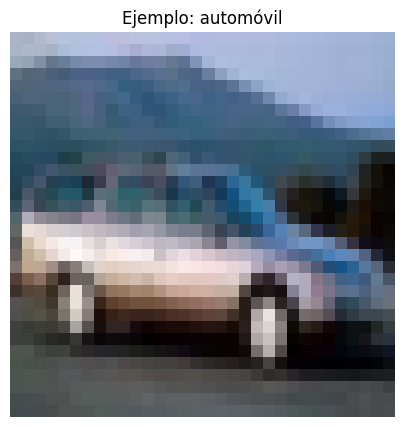

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(x_train_a[0])
plt.title(f'Ejemplo: {labels[modelo_a_clases[y_train_a[0][0]]]}')
plt.axis('off')
plt.show()


Entrena el Modelo A

In [12]:


# Crear carpetas si no existen
os.makedirs('Checkpoints', exist_ok=True)
os.makedirs('modelos/4_7_2', exist_ok=True)

# Preparar los datos
x_train_a = x_train_a.reshape(-1, 32, 32, 3)
x_test_a = x_test_a.reshape(-1, 32, 32, 3)

# Dividir en entrenamiento y validación
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(
    x_train_a, y_train_a, test_size=0.2, random_state=42
)

# Crear el modelo A
model_A = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 grupos
])

# Compilar el modelo
model_A.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "Checkpoints/4_7_2.weights.h5", 
    save_weights_only=True
)

# Para que el modelo pare si en 10 iteraciones no mejora
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)

# Entrenar el modelo
history_A = model_A.fit(
    x_train_a,
    y_train_a,
    epochs=100,
    validation_data=(x_val_a, y_val_a),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

# Evaluar el modelo
test_loss, test_accuracy = model_A.evaluate(x_test_a, y_test_a)
print(f"Precisión en test: {test_accuracy}")

# Guardar el modelo
model_A.save("modelos/4_7_2/modelo_A.keras")

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.4624 - loss: 1.2415 - val_accuracy: 0.6130 - val_loss: 1.0037
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5893 - loss: 1.0120 - val_accuracy: 0.6308 - val_loss: 0.9466
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6258 - loss: 0.9426 - val_accuracy: 0.6255 - val_loss: 0.9250
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6413 - loss: 0.8973 - val_accuracy: 0.6317 - val_loss: 0.9016
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6541 - loss: 0.8653 - val_accuracy: 0.6378 - val_loss: 0.8896
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.6682 - loss: 0.8318 - val_accuracy: 0.6500 - val_loss: 0.8707
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6893 - loss: 0.8056 - val_accuracy: 0.6572 - val_loss: 0.8545
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6917 - loss: 0.7851 - 

Entrenar el Modelo B desde 0

In [ ]:
# Prepare the data
x_train_b = x_train_b.reshape(-1, 32, 32, 3)
x_test_b = x_test_b.reshape(-1, 32, 32, 3)

# Split into training and validation sets
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(
    x_train_b, y_train_b, test_size=0.2, random_state=42
)

# Create Model B
model_B = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32,32,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 groups
])

# Compile the model
model_B.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "Checkpoints/4_7_2_B.weights.h5", 
    save_weights_only=True
)

# Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True
)

# Train the model
history_B = model_B.fit(
    x_train_b,
    y_train_b,
    epochs=100,
    validation_data=(x_val_b, y_val_b),
    callbacks=[checkpoint_cb, early_stopping_cb],
)

# Evaluate the model
test_loss, test_accuracy = model_B.evaluate(x_test_b, y_test_b)
print(f"Precision en test: {test_accuracy}")

# Save the model
model_B.save("modelos/4_7_2/modelo_B.keras")

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3923 - loss: 1.3214 - val_accuracy: 0.4453 - val_loss: 1.2002
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.5105 - loss: 1.1167 - val_accuracy: 0.4755 - val_loss: 1.1658
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5417 - loss: 1.0626 - val_accuracy: 0.4913 - val_loss: 1.1618
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5628 - loss: 1.0243 - val_accuracy: 0.5013 - val_loss: 1.1520
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5692 - loss: 1.0158 - val_accuracy: 0.4960 - val_loss: 1.1947
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5846 - loss: 0.9952 - val_accuracy: 0.4945 - val_loss: 1.1976
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5918 - loss: 0.9826 - val_accuracy: 0.5038 - val_loss: 1.1659
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6029 - loss: 0.9608 - val

Entrenar el Modelo B utilizando las capas aprendidas del Modelo A (excepto la capa de salida)

In [18]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

# Modelo de B con las capas de A (menos la última)
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(4, activation="softmax"))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

history_frozen = model_B_on_A.fit(
    x_train_b, 
    y_train_b, 
    epochs=20, 
    validation_data=(x_val_b, y_val_b)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

history_unfrozen = model_B_on_A.fit(
    x_train_b, 
    y_train_b, 
    epochs=20, 
    validation_data=(x_val_b, y_val_b)
)

test_loss, test_accuracy = model_B_on_A.evaluate(x_test_b, y_test_b)
print(f"Precision en test: {test_accuracy}")

model_B_on_A.save("modelos/4_7_2/modelo_B_transferencia.keras")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3185 - loss: 1.7465 - val_accuracy: 0.4252 - val_loss: 1.2804
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4326 - loss: 1.2622 - val_accuracy: 0.4507 - val_loss: 1.2272
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4622 - loss: 1.2190 - val_accuracy: 0.4625 - val_loss: 1.2072
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4759 - loss: 1.1995 - val_accuracy: 0.4665 - val_loss: 1.1968
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4823 - loss: 1.1882 - val_accuracy: 0.4723 - val_loss: 1.1908
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4875 - loss: 1.1813 - val_accuracy: 0.4740 - val_loss: 1.1871
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4913 - loss: 1.1763 - val_accuracy: 0.4798 - val_loss: 1.1847
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4926 - loss: 1.1728 - val_accuracy: 0.

Evaluar los dos modelos para el conjunto de datos B en el conjunto de pruebas

In [19]:
# Evaluar Modelo B original
print("Evaluación de Modelo B original:")
test_loss, test_accuracy = model_B.evaluate(x_test_b, y_test_b)
print(f"Precisión en test: {test_accuracy}")

# Evaluar Modelo B basado en A
print("\nEvaluación de Modelo B basado en A:")
test_loss, test_accuracy = model_B_on_A.evaluate(x_test_b, y_test_b)
print(f"Precisión en test: {test_accuracy}")

Evaluación de Modelo B original:
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5706 - loss: 1.0333
Precisión en test: 0.5727499723434448

Evaluación de Modelo B basado en A:
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6091 - loss: 0.9590
Precisión en test: 0.6184999942779541


¿En este caso merece la pena?

Sí, da mejor precisión